# imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import catboost as cb
from sklearn.model_selection import train_test_split
from pathlib import Path
import hyperopt
import shap
shap.initjs()

/home/alexander/Documents/catboost-learning/.venv/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# data exploration

Import data and look into the data types. We can see that `TotalCharges` is of type `object` (likely a string), so we're gonna cast it to float. We also see that `SeniorCitizen` is `int64`, so we are probably going to cast it to `str`. 

In [3]:
data_file = Path('~/Documents/catboost-learning/data/WA_Fn-UseC_-Telco-Customer-Churn.xls')

df = pd.read_csv(data_file)
print(df.shape[0])
print(df.dtypes)

7043
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [4]:
print(df[df.TotalCharges == ' '])

      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  ... 

We get an error while trying to cast `TotalCharges` to `float`, so we explore the entries with empty (` ` space) entries. We see there are 11 entries with empty `TotalCharges`, 10 of them have a 2-year contract, with a single 1-year contract, and tenure for all 11 is 0 -- likely new customers for whom no payment was yet made, so we fill the TotalCharges as 0. and convert the TotalCharges data from `str` to `float`.

In [5]:
df.loc[df.TotalCharges == ' ','TotalCharges'] = '0'
df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)
df['TotalCharges'] = df['TotalCharges'].astype(float)

Let's take a look at the targets. We notice that there is a slight class imbalance in favor of non-churners -- roughly 3:1 -- which means roughly 1 out of 4 customers churns. 

In [6]:
print(np.unique(df['Churn'], return_counts=True))

(array(['No', 'Yes'], dtype=object), array([5174, 1869]))


Finally, let's take a look at the feature values. We can see that we should drop customerID for training. We also see that MonthlyCharges, TotalCharges and tenure might be correlated through TotalCharges = MonthlyCharges * tenure, but let's leave that for the model to handle, at least for now. 

In [7]:
for c in df.columns:
    print(c, df[c].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
SeniorCitizen ['0' '1']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit car

# data preparation

In [23]:
y = df['Churn']
x = df.drop('Churn', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, stratify=y)

id_train = x_train['customerID']
id_test = x_test['customerID']

x_train_features = x_train.drop(columns=['customerID'])
x_test_features = x_test.drop(columns=['customerID'])

cat_features = [c for c, v in x_train_features.items() if v.dtype =='object'] or None

# catboost training

## hyperopt setup

In [24]:
class hyperoptObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
    
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'depth': hyper_params['depth'],
            'l2_leaf_reg': hyper_params['l2_leaf_reg'],
        }

    def __call__(self, hyper_params):
        catboost_params = self._to_catboost_params(hyper_params)
        catboost_params.update(self._const_params)
        # Set logging_level to Silent to suppress all output during CV
        catboost_params['logging_level'] = 'Silent'
        cv_results = cb.cv(
            pool=self._dataset,
            params=catboost_params,
            fold_count=self._fold_count,
            stratified=True,
            verbose=False,
            partition_random_seed=42,
            )
        max_mean_auc = np.max(cv_results['test-PRAUC-mean'])
        print(f'evaluated score={max_mean_auc}')
        self._evaluated_count += 1
        return {"loss": -max_mean_auc, "status": hyperopt.STATUS_OK}


def find_best_hyperparams(dataset, const_params, max_evals=100):
    parameter_space = {
        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.01, 1.),
        'depth': hyperopt.hp.randint('depth', 2, 7),
        'l2_leaf_reg': hyperopt.hp.uniform('l2_leaf_reg', 1, 10),
    }
    objective = hyperoptObjective(dataset, const_params, 5)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals,
        trials=trials,
        rstate=np.random.default_rng(seed=42),
    )
    return best


def train_model(x, y, cat_features, const_params, max_evals=100, hyper_params=None):
    dataset = cb.Pool(x, y, cat_features=cat_features)
    if hyper_params is None:
        hyper_params = find_best_hyperparams(dataset, const_params, max_evals)
    catboost_params = const_params.copy()
    catboost_params.update(hyper_params)
    catboost_params.pop('use_best_model', None)
    # Set logging_level to Silent to suppress output during training
    catboost_params['logging_level'] = 'Silent'
    model = cb.CatBoostClassifier(**catboost_params)
    model.fit(dataset, verbose=False)
    return model, hyper_params

        

## Training: catboost + hyperopt

In [25]:
const_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'PRAUC',
    'iterations': 100,
    'random_seed': 42,
    # 'class_weights': [1, 6],
    'auto_class_weights': 'Balanced',
    'use_best_model': True,
    'ignored_features': ['TotalCharges']
}

use_hyper = True
hyper_params = {"depth": 3, "l2_leaf_reg": 1.662949, "learning_rate": 0.155493159} if use_hyper else None

model, params = train_model(x_train_features,
                            y_train, 
                            cat_features, 
                            const_params, 
                            max_evals=10, 
                            hyper_params=hyper_params)
print(f'best params: {params}')


best params: {'depth': 3, 'l2_leaf_reg': 1.662949, 'learning_rate': 0.155493159}


In [26]:
def calculate_score(model, x, y, cat_features):
    import sklearn.metrics
    import matplotlib.pylab as pl
    import catboost.utils as cbu
    pl.style.use('ggplot')
    
    dataset = cb.Pool(x, y, cat_features=cat_features)
    fpr, tpr, thresholds = cbu.get_roc_curve(model, dataset, plot=True)
    auc = sklearn.metrics.auc(fpr, tpr)
    return auc

## model performance summary

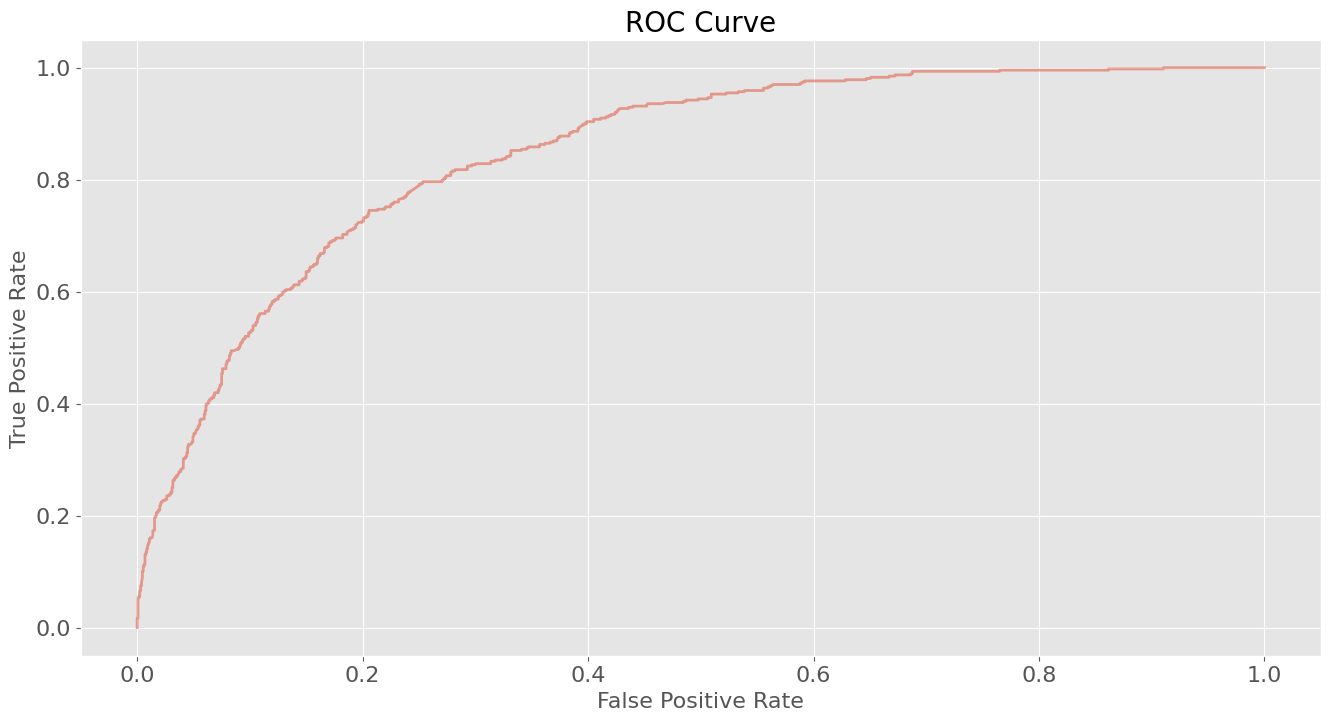

0.847081241374289

In [27]:
calculate_score(model, x_test_features, y_test, cat_features)

Verify positive class is "yes (churn)". Then false positives are users predicted to churn who did not churn, and false negatives are users who were predicted to not churn but churned. 

In [57]:
# Check the class order
print("Class order:", model.classes_)
print("Class 0 (negative):", model.classes_[0])
print("Class 1 (positive):", model.classes_[1])

# Check predictions
# predict_proba returns probabilities in class order
proba = model.predict_proba(x_test_features[:5])
print("\nFirst 5 predictions (probabilities):")
print("Probabilities shape:", proba.shape)
print("Column 0 = P(No), Column 1 = P(Yes)")
print(proba)

feature_importances = model.get_feature_importance()
for i, importance in enumerate(feature_importances):
    print(f"{x_train_features.columns[i]}: {importance:.02f}")


Class order: ['No' 'Yes']
Class 0 (negative): No
Class 1 (positive): Yes

First 5 predictions (probabilities):
Probabilities shape: (5, 2)
Column 0 = P(No), Column 1 = P(Yes)
[[0.68752948 0.31247052]
 [0.85965085 0.14034915]
 [0.92948226 0.07051774]
 [0.08662972 0.91337028]
 [0.92118059 0.07881941]]
gender: 0.90
SeniorCitizen: 0.51
Partner: 0.00
Dependents: 0.83
tenure: 18.15
PhoneService: 0.39
MultipleLines: 1.13
InternetService: 3.44
OnlineSecurity: 5.98
OnlineBackup: 1.42
DeviceProtection: 0.00
TechSupport: 3.08
StreamingTV: 0.27
StreamingMovies: 0.63
Contract: 41.44
PaperlessBilling: 2.85
PaymentMethod: 3.56
MonthlyCharges: 15.41
TotalCharges: 0.00


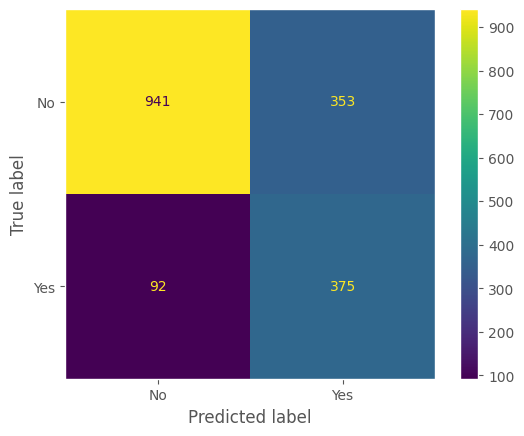

We are able to detect (recall) 80.30% of churn instances correctly with a precision of 51.51%


In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_fit = model.predict(x_test_features)

cm = confusion_matrix(y_test, y_fit, labels=y_test.unique())
ConfusionMatrixDisplay(cm, display_labels=y_test.unique()).plot()
plt.grid(False)
plt.show()

print(f"We are able to detect (recall) {100*(cm[1, 1] / (cm[1, 1] + cm[1, 0])):.02f}% of churn instances correctly \
with a precision of {100*(cm[1,1] / (cm[1,1] + cm[0,1])):.02f}%")

## SHAP: feature importance

Print out the legend for categorical variables. 

We can see from SHAP analysis that the Contract type has largest influence on the result -- users with 2 year contract are least likely to churn, while users with month-to-month contract are most likely to churn, and the variability within groups is smaller than variability between groups -- the beeswarm plot shows clear separation between the 3 user groups. 

The second most important feature are the monthly charges, where users with higher monthly charges are more likely to churn. 

New users seem to be more likely to churn as well, as can be seen from the beeswarm plot for tenure. 

Users with no internet security, no tech support, or Fiber optic as their type of internet service seem to be more likely to churn as well. 

The users with low TotalCharges are likely to be the users with low tenure -- can be verified by exploring feature correlation, perhaps something to do later. 

We could also split the data based on Contract type, and predict churn for each of the 3 classes separately, or separating into 1- or 2- year contract vs month-to-month contracts. Perhaps we can act on each of these 2 groups (month-to-month vs longer contracts) separately. 

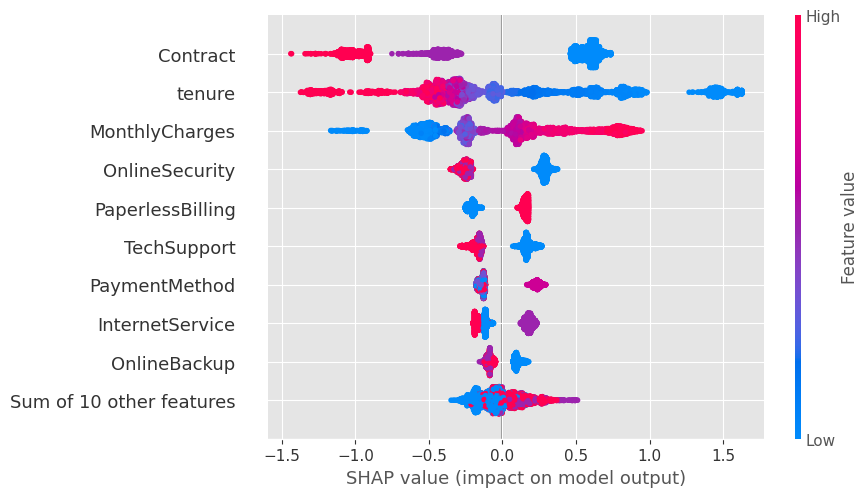

CATEGORICAL VALUE ENCODING LEGEND

This legend shows which numeric codes correspond to which categorical values
in the SHAP beeswarm plot above. The colors in the plot represent these codes.


gender:	 0 → Female	 1 → Male	
SeniorCitizen:	 0 → 0	 1 → 1	
Partner:	 0 → No	 1 → Yes	
Dependents:	 0 → No	 1 → Yes	
PhoneService:	 0 → No	 1 → Yes	
MultipleLines:	 0 → No	 1 → No phone service	 2 → Yes	
InternetService:	 0 → DSL	 1 → Fiber optic	 2 → No	
OnlineSecurity:	 0 → No	 1 → No internet service	 2 → Yes	
OnlineBackup:	 0 → No	 1 → No internet service	 2 → Yes	
DeviceProtection:	 0 → No	 1 → No internet service	 2 → Yes	
TechSupport:	 0 → No	 1 → No internet service	 2 → Yes	
StreamingTV:	 0 → No	 1 → No internet service	 2 → Yes	
StreamingMovies:	 0 → No	 1 → No internet service	 2 → Yes	
Contract:	 0 → Month-to-month	 1 → One year	 2 → Two year	
PaperlessBilling:	 0 → No	 1 → Yes	
PaymentMethod:	 0 → Bank transfer (automatic)	 1 → Credit card (automatic)	 2 → Electronic check	 3 → Mail

In [30]:
# Create numeric encoding for categoricals
X_train_encoded = x_train_features.copy()
for col in cat_features:
    X_train_encoded[col] = pd.Categorical(x_train_features[col]).codes

# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train_features)

# Create explanation with encoded data for coloring
explanation = shap.Explanation(
    values=shap_values,
    data=X_train_encoded.values,  # Numeric encoding for color scale
    feature_names=x_train_features.columns
)

shap.plots.beeswarm(explanation)

# Create legend showing categorical value encodings
print("=" * 80)
print("CATEGORICAL VALUE ENCODING LEGEND")
print("=" * 80)
print("\nThis legend shows which numeric codes correspond to which categorical values")
print("in the SHAP beeswarm plot above. The colors in the plot represent these codes.\n")

categorical_encodings = {}
for col in cat_features:
    # Get unique values and their codes using pd.Categorical
    cat = pd.Categorical(x_train_features[col])
    # categories[i] corresponds to code i
    encoding_map = {i: cat.categories[i] for i in range(len(cat.categories))}
    categorical_encodings[col] = encoding_map

# Display the encodings in a readable format
for col, encoding in categorical_encodings.items():
    print(f"\n{col}:", end='\t')
    for code in sorted(encoding.keys()):
        value = encoding[code]
        print(f"{code:2d} → {value}", end='\t')

print("\n" + "=" * 80)

Waterfall plots for 2 selected false positives and false negatives, respectively. False negatives represent users that were predicted to stay with the service, but walked away (predicted churn as no churn), whereas false positives represent users who did not churn but were predicted as churn.

The first false positive (top left) is a new user with tenure of 1 on a month-to-month contract. Low tenure and low total charges pushed the model to predict it as a resigning user (churn). Perhaps after some feature engineering to account for tenure and total charges being correlated, this type of false positives can be avoided. It is worth noting that it is a brand new user with a month-to-month contract, which will likely be the most difficult case to make accurate churn predictions for. 

The second false positive (bottom left) is a month-to-month subscriber as well, where the influence of the contract type was sufficient to classify the user as a churner. 

The first false negative (top right) ...


The second false negative (bottom right) ...


Total False Positives: 353
Total False Negatives: 92


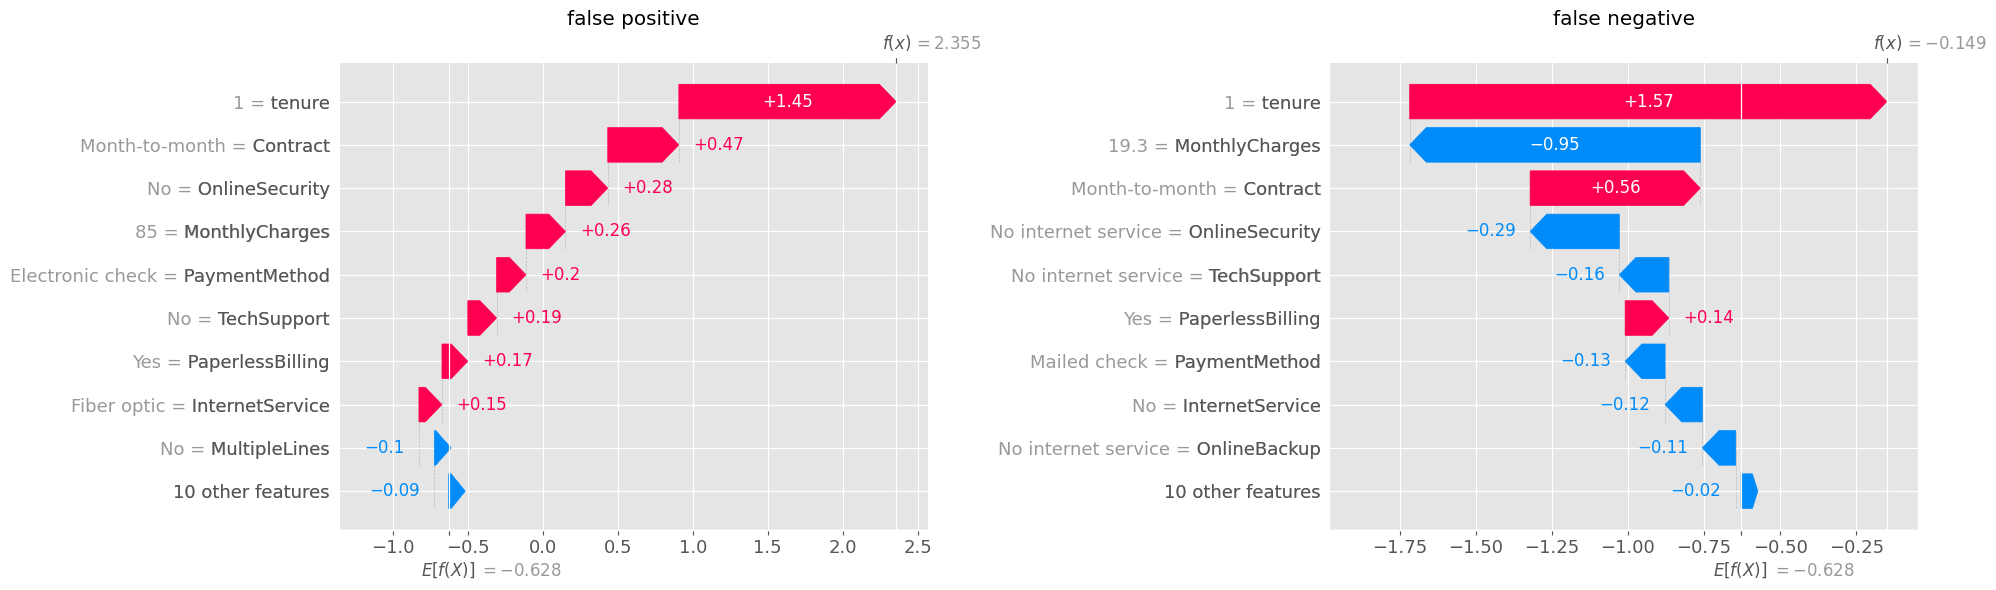

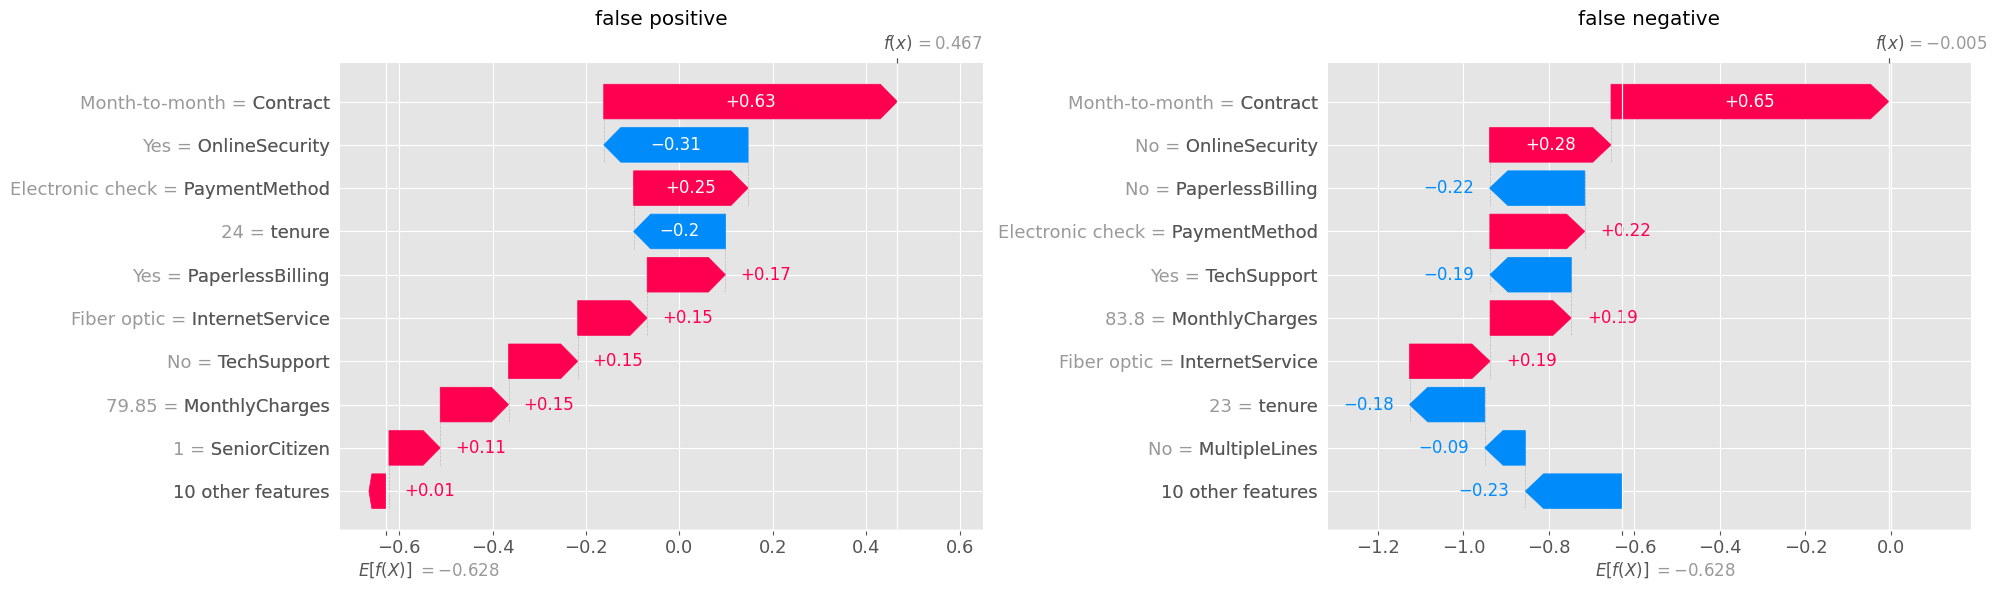

In [31]:
# Calculate false positives and false negatives
# False Positives: Predicted "Yes" (churn) but actual is "No" (no churn)
# False Negatives: Predicted "No" (no churn) but actual is "Yes" (churn)

# Convert to boolean arrays for easier indexing
# Assuming "Yes" is the positive class (churn)
y_test_bool = (y_test == 'Yes')
y_fit_bool = (y_fit == 'Yes')

# False Positives: predicted churn but didn't actually churn
fps = np.where((y_fit_bool == True) & (y_test_bool == False))[0]

# False Negatives: predicted no churn but actually churned
fns = np.where((y_fit_bool == False) & (y_test_bool == True))[0]

print(f"Total False Positives: {len(fps)}")
print(f"Total False Negatives: {len(fns)}")

explainer = shap.Explainer(model, feature_perturbation='tree_path_dependent')
shap_values = explainer(x_test_features)

fig = plt.figure()
ax0 = fig.add_subplot(121)
shap.plots.waterfall(shap_values[fps[0]], show=False)
plt.title('false positive')
fig.add_subplot(122)
shap.plots.waterfall(shap_values[fns[0]], show=False)
plt.title('false negative')
plt.gcf().set_size_inches(20,6)
plt.tight_layout()
plt.show()

fig = plt.figure()
ax0 = fig.add_subplot(121)
shap.plots.waterfall(shap_values[fps[1]], show=False)
plt.title('false positive')
fig.add_subplot(122)
shap.plots.waterfall(shap_values[fns[1]], show=False)
plt.title('false negative')
plt.gcf().set_size_inches(20,6)
plt.tight_layout()
plt.show()


# xgboost

In [32]:
import xgboost as xgb

print(xgb.__version__)

3.1.3


In [33]:
xgb_x_train_features = x_train_features.copy()
xgb_x_train_features[cat_features] = xgb_x_train_features[cat_features].astype('category')
xgb_x_test_features = x_test_features.copy()
xgb_x_test_features[cat_features] = xgb_x_test_features[cat_features].astype('category')
xgb_y_train = y_train.copy()
xgb_y_test = y_test.copy()
xgb_y_train[xgb_y_train == "No"] = 0
xgb_y_train[xgb_y_train == "Yes"] = 1
xgb_y_test[xgb_y_test == "No"] = 0
xgb_y_test[xgb_y_test == "Yes"] = 1



In [34]:
# Calculate scale_pos_weight for imbalanced classes
# Ratio of negative class (No) to positive class (Yes)
# From data: 5174 "No" vs 1869 "Yes" ≈ 2.77:1
scale_pos_weight = (xgb_y_train == 0).sum() / (xgb_y_train == 1).sum()

model_xgb = xgb.XGBClassifier(tree_method='hist',
                              objective='binary:logistic',
                              enable_categorical=True, 
                              eval_metric='aucpr',  # PR-AUC is better for imbalanced classes
                              scale_pos_weight=scale_pos_weight,  # Handle class imbalance
                              random_state=42,
                              learning_rate=hyper_params['learning_rate'],
                              reg_lambda=hyper_params['l2_leaf_reg'],
                              max_depth=hyper_params['depth'],
                              n_estimators=100,
                              )
model_xgb.fit(xgb_x_train_features, xgb_y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,True
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

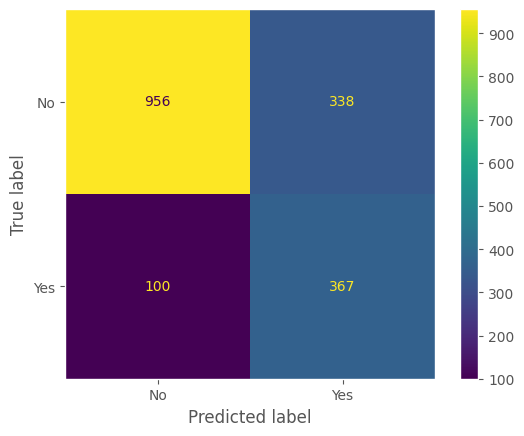

We are able to detect (recall) 78.59% of churn instances correctly with a precision of 52.06%


In [36]:
xgb_y_fit = model_xgb.predict(xgb_x_test_features)
# print(xgb_y_fit[0], xgb_y_test[0])
# print(type(xgb_y_fit[0]), type(xgb_y_test[0]))
# print(np.unique(xgb_y_fit[0], return_counts=True))
# print(np.unique(xgb_y_test[0], return_counts=True))

cm = confusion_matrix(xgb_y_test.astype(int), xgb_y_fit)
ConfusionMatrixDisplay(cm, display_labels=["No", "Yes"]).plot()
plt.grid(False)
plt.show()

print(f"We are able to detect (recall) {100*(cm[1, 1] / (cm[1, 1] + cm[1, 0])):.02f}% of churn instances correctly \
with a precision of {100*(cm[1,1] / (cm[1,1] + cm[0,1])):.02f}%")

# logistic regression

In [47]:
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.preprocessing import OneHotEncoder

print(sklearn.__version__)

enc = OneHotEncoder(handle_unknown='ignore')
x_train_ohe = enc.fit_transform(x_train_features[cat_features])
x_test_ohe = enc.transform(x_test_features[cat_features])

lr_model = LogisticRegression(class_weight='balanced',
                              max_iter=100,
                              random_state=42,
                              )
lr_model.fit(x_train_ohe, y_train)
lr_y_fit = lr_model.predict(x_test_ohe)


1.8.0


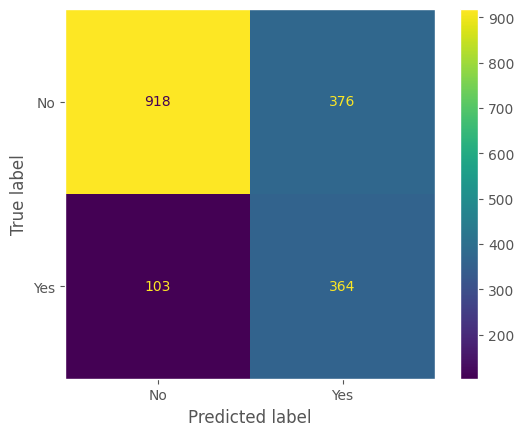

We are able to detect (recall) 77.94% of churn instances correctly with a precision of 49.19%


In [48]:
cm = confusion_matrix(y_test, lr_y_fit)
ConfusionMatrixDisplay(cm, display_labels=y_test.unique()).plot()
plt.grid(False)
plt.show()

print(f"We are able to detect (recall) {100*(cm[1, 1] / (cm[1, 1] + cm[1, 0])):.02f}% of churn instances correctly \
with a precision of {100*(cm[1,1] / (cm[1,1] + cm[0,1])):.02f}%")